<img src="./logo_UTN.svg" align="right" width="200" /> 

#### Teoría de los Circuitos 2

# Trabajo semanal 8

#### Ana Nuñez



# Consigna

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

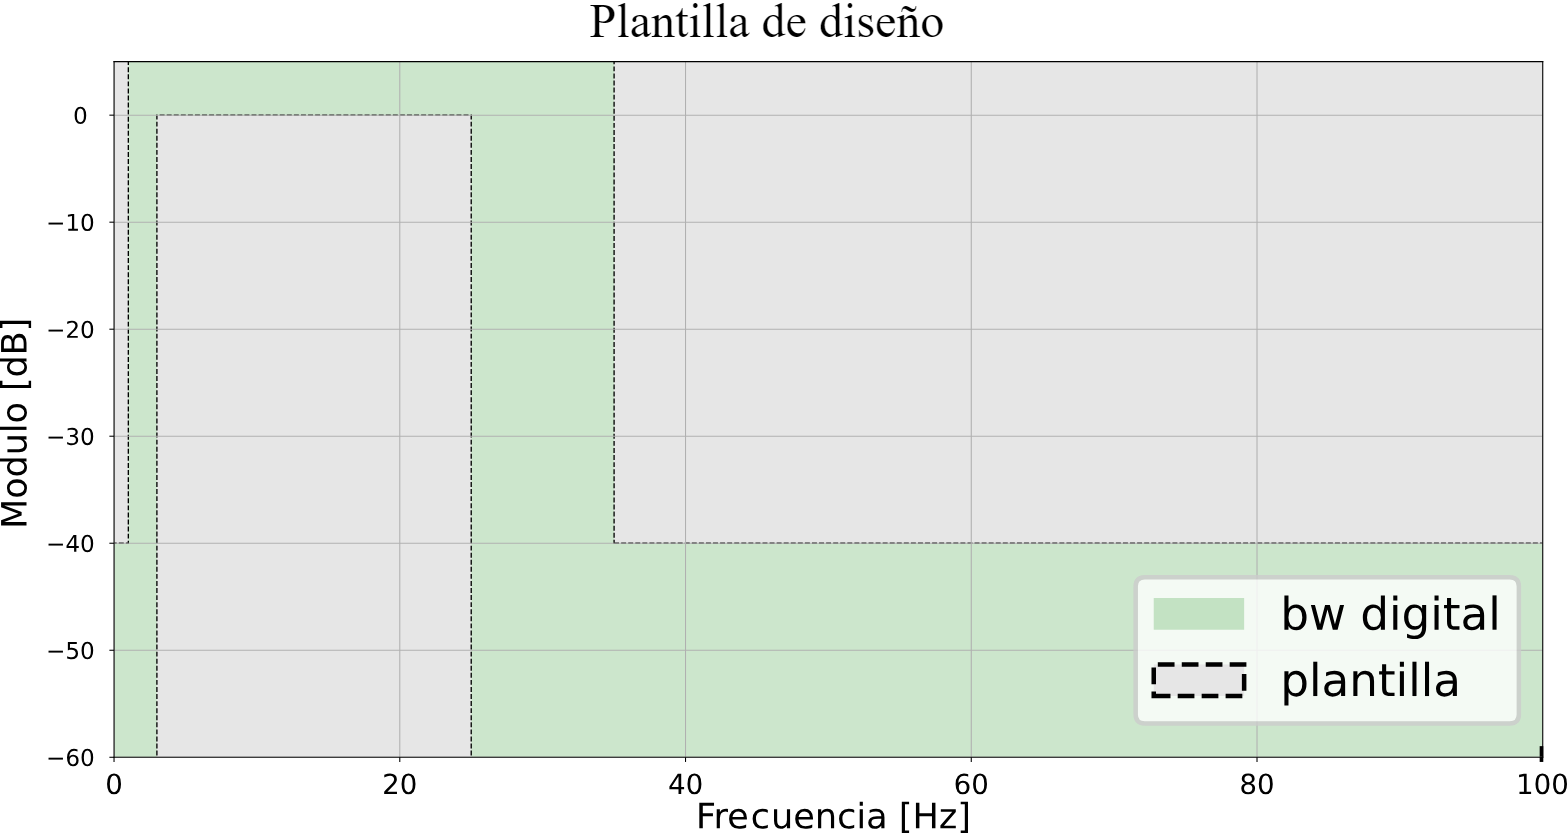

y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo,

b) fase

c) retardo

d) y respuesta al impulso.


Parte II - Implementación y uso

En esta parte utilizaremos los dos filtros diseñados para mitigar las interferencias. Para ello se dispone de un notebook de referencia para facilitar la experimentación.

# 1. Simulación numérica circuital

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

#%% Inicializacion de graficos para el Notebook
plt.figure(1)
plt.close(1)

import matplotlib as mpl

fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})
#%%  Fin - Inicialización de librerías + Inicializacion de gráficos para el Notebook


In [2]:
# -----------------------------------------ECG---------------------------------------------

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)


In [3]:
# --------------------------------Definicion de parámetros---------------------------------

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0.1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

In [4]:
# -----------------------------------------IIR---------------------------------------------

system = sig.iirdesign(wp = [wp1, wp2], ws = [ws1, ws2], gpass = ripple, gstop = atenuacion, analog = False, ftype = 'butter', output = 'sos', fs = 1000)

print(f"El filtro tiene {system.shape[0]} SOS")

w, TF_IIR = sig.sosfreqz(system, worN = 2000, fs = fs)

phase = np.angle(TF_IIR)

num_IIR, den_IIR = sig.sos2tf(system)
w, gd = sig.group_delay((num_IIR, den_IIR), w = 2000, whole = False, fs = fs)

El filtro tiene 17 SOS


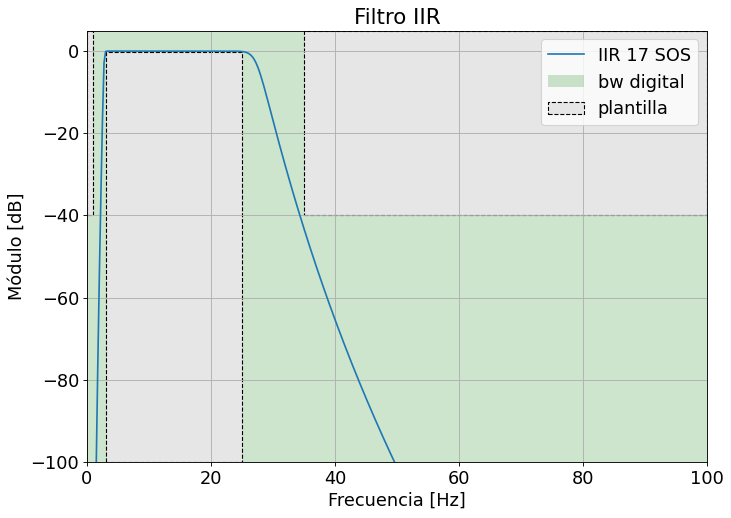

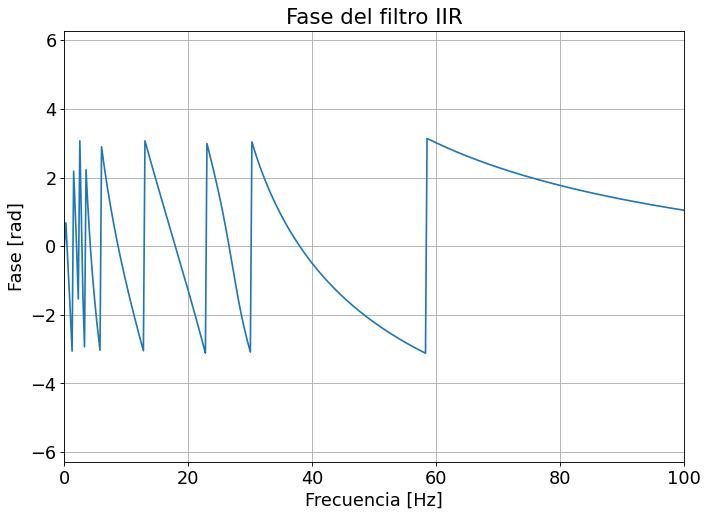

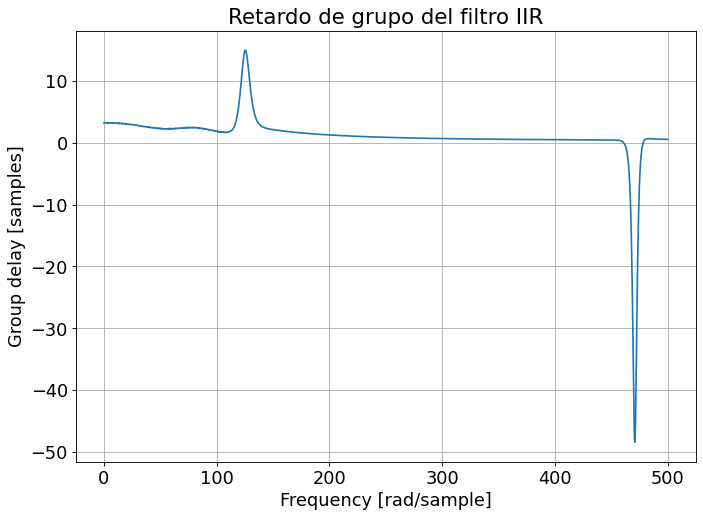

In [5]:
# ----- Modulo -----

plt.figure(1)

plt.plot(w, 20 * np.log10(abs(TF_IIR)), label = 'IIR {:d} SOS'.format(system.shape[0]))

plt.title('Filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -100, 5 ])

plot_plantilla(filter_type = 'bandpass', fpass = [wp1, wp2], ripple = ripple , fstop = [ws1, ws2], attenuation = atenuacion, fs = fs)

# ----- Fase -----

plt.figure(2)

plt.plot(w, phase)
plt.title('Fase del filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, 100, -2*np.pi, 2*np.pi ])

# ----- Group delay -----

plt.figure(3)

plt.plot(w, gd)
plt.title('Retardo de grupo del filtro IIR')
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()


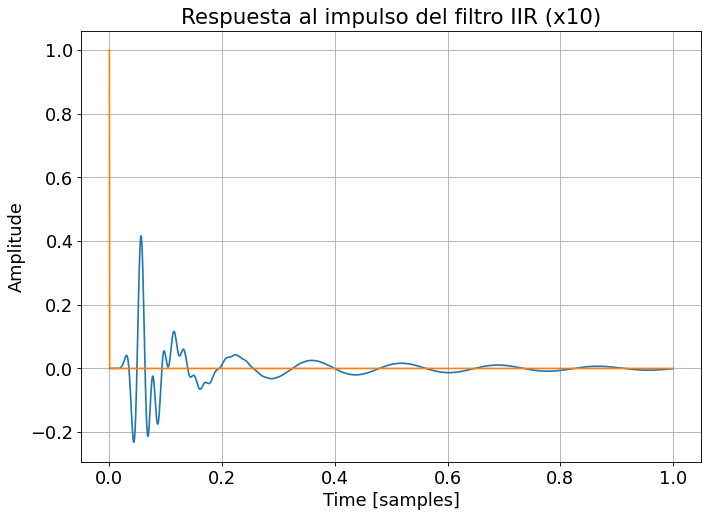

In [16]:
#------------------------ Respuesta al impulso del filtro IIR ------------------------

impulse = sig.unit_impulse(2000)
response = sig.sosfilt(system, impulse)

plt.plot(np.linspace(0,1, 2000), response * 10) # Para que se vea mas claro en el gráfico
plt.plot(np.linspace(0,1, 2000), impulse)
#plt.xlim([0,0.2])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.title('Respuesta al impulso del filtro IIR (x10)')

plt.grid(True)
plt.show()

In [6]:
# -----------------------------------------FIR---------------------------------------------

#-----Definicion de parámetros-----

frecs = np.array([        0.0,          ws1,         wp1,        wp2,           ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion,  -atenuacion,     -ripple,    -ripple,   -atenuacion,        -atenuacion ])
gains = 10**(gains/20)


In [7]:
#-----Obtengo la transferencia-----

cant_coef = 5501

num_win = sig.firwin2(cant_coef, frecs, gains , window='hamming')
den = 1.0

# Muestreo el filtro donde me interesa verlo según la plantilla

w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, TF_FIR = sig.freqz(num_win, den, w)

# Renormalizo el eje de frecuencia

w = w / np.pi * nyq_frec

phase = np.angle(TF_FIR)
wg, gd = sig.group_delay((num_win, den), w = 2000, whole = False, fs = fs)


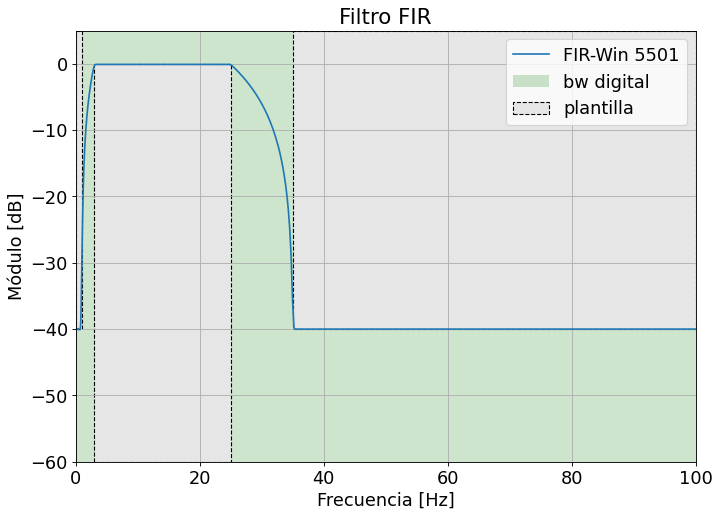

(0.0, 500.0, 0.0, 5000.0)

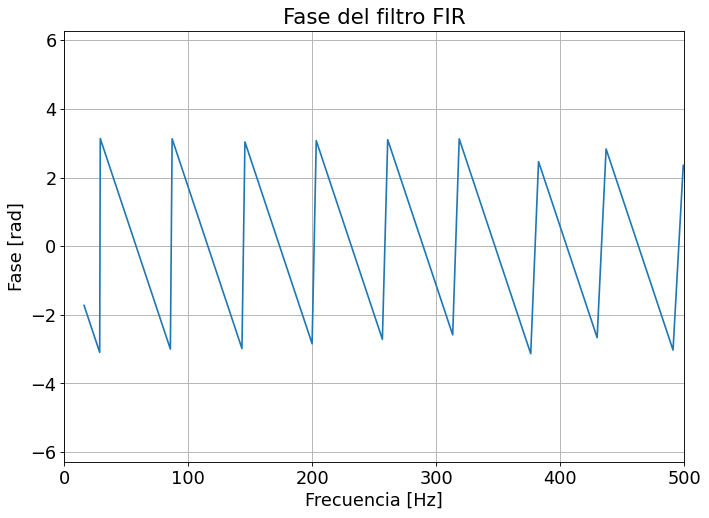

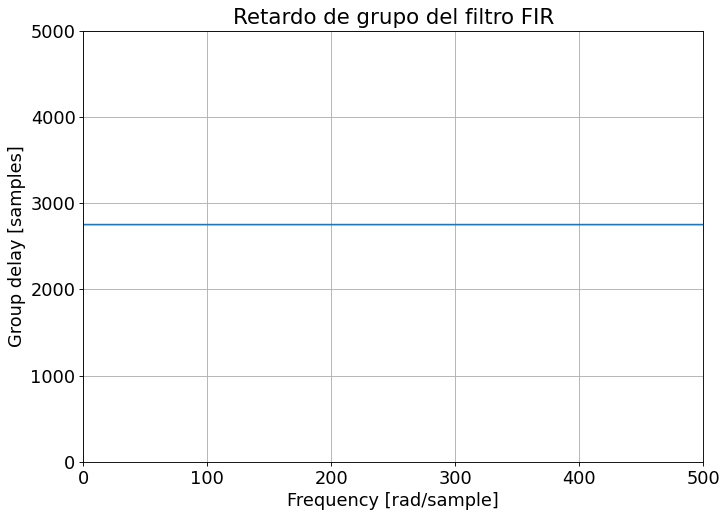

In [8]:
# ----- Modulo -----

plt.figure(4)

plt.plot(w, 20 * np.log10(abs(TF_FIR)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ])

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [wp1, wp2], ripple = ripple , fstop = [ws1, ws2], attenuation = atenuacion, fs = fs)


# ----- Fase -----

plt.figure(5)

plt.plot(w / np.pi * nyq_frec, phase)
plt.title('Fase del filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi ])

# ----- Group delay -----

plt.figure(3)

plt.plot(wg, gd)
plt.title('Retardo de grupo del filtro FIR')
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.axis([0, nyq_frec, 0, 5000])

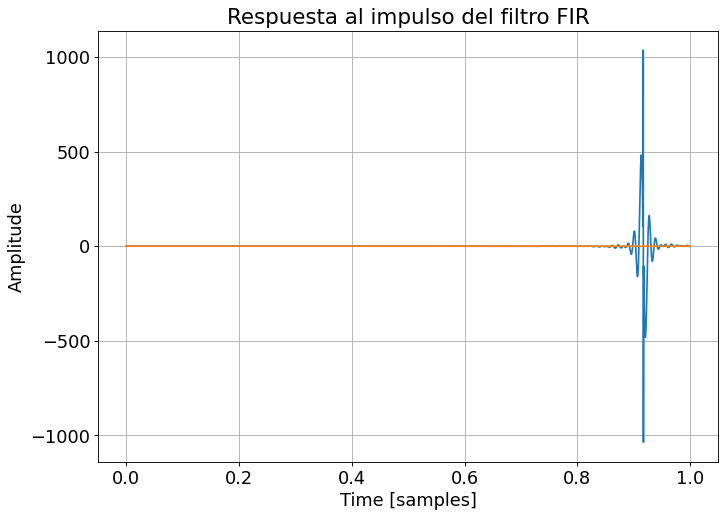

In [26]:

#------------------------ Respuesta al impulso del filtro FIR ------------------------

impulse = sig.unit_impulse(3000)
response = sig.lfilter(num_win, den, impulse)

plt.plot(np.linspace(0, 1, 3000), response * (10 ** 5)) # Para que se vea mas claro en el gráfico
plt.plot(np.linspace(0, 1, 3000), impulse)
#plt.xlim([0,0.2])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.title('Respuesta al impulso del filtro FIR')

plt.grid(True)
plt.show()

In [9]:
#####################################
#                                   #
#               Parte 2             #
#                                   #
##################################### 


# IIR
# ECG_f_IIR = sig.sosfilt(system, ecg_one_lead)

# FIR
ECG_f_FIR = sig.lfilter(num_win, den, ecg_one_lead)

# Calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = int (gd[0])

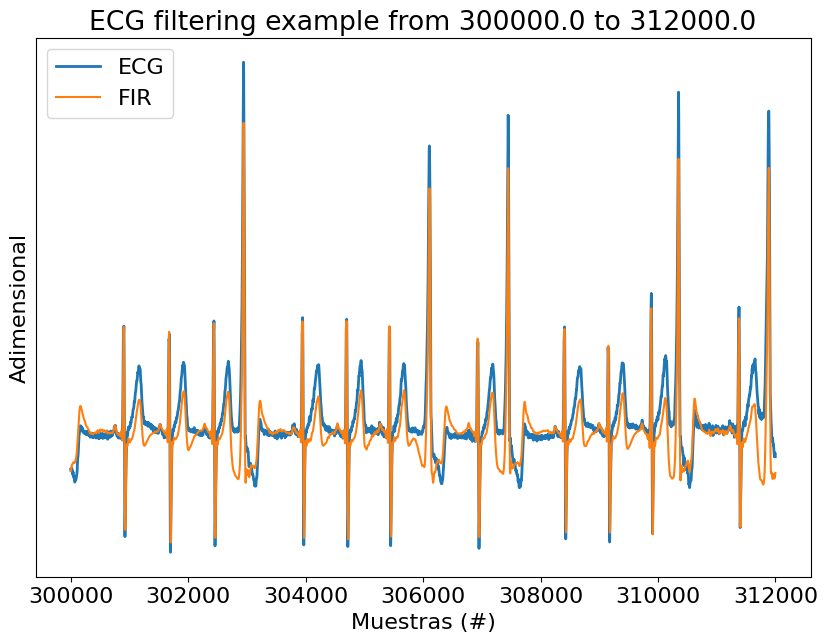

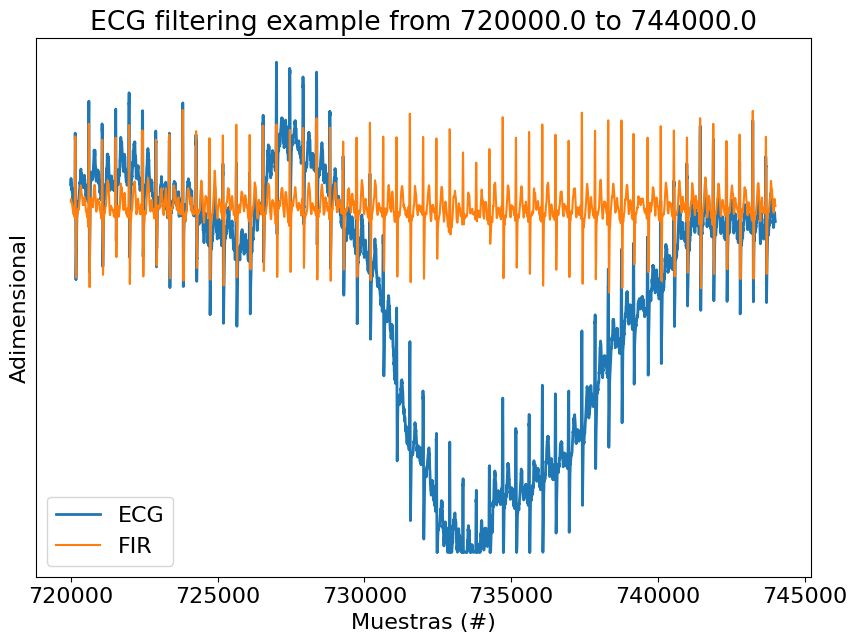

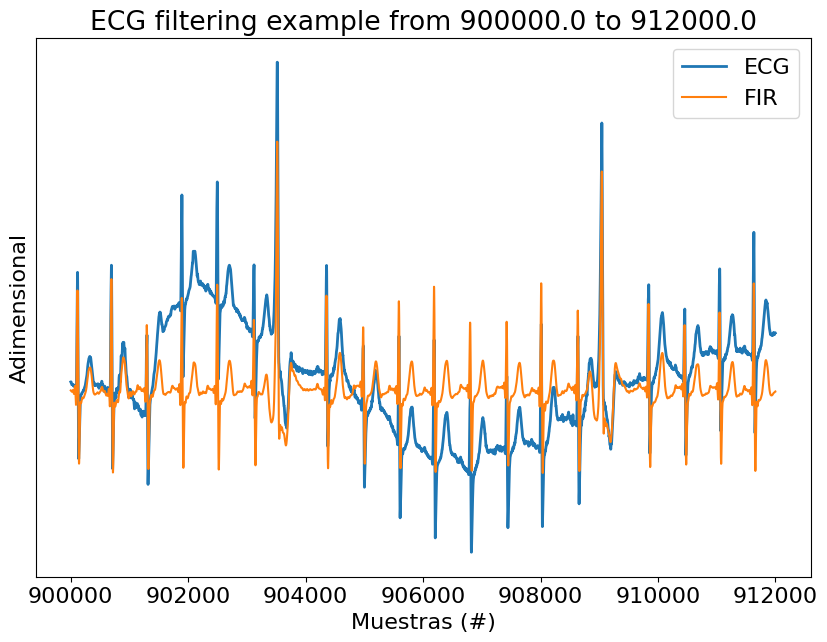

In [10]:
# -------------------------- Segmentos de interés con ALTA contaminación ---------------------------

regs_interes = ( 
        np.array([5, 5.2])   * 60 * fs, # minutos a muestras
        np.array([12, 12.4]) * 60 * fs, # minutos a muestras
        np.array([15, 15.2]) * 60 * fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
    

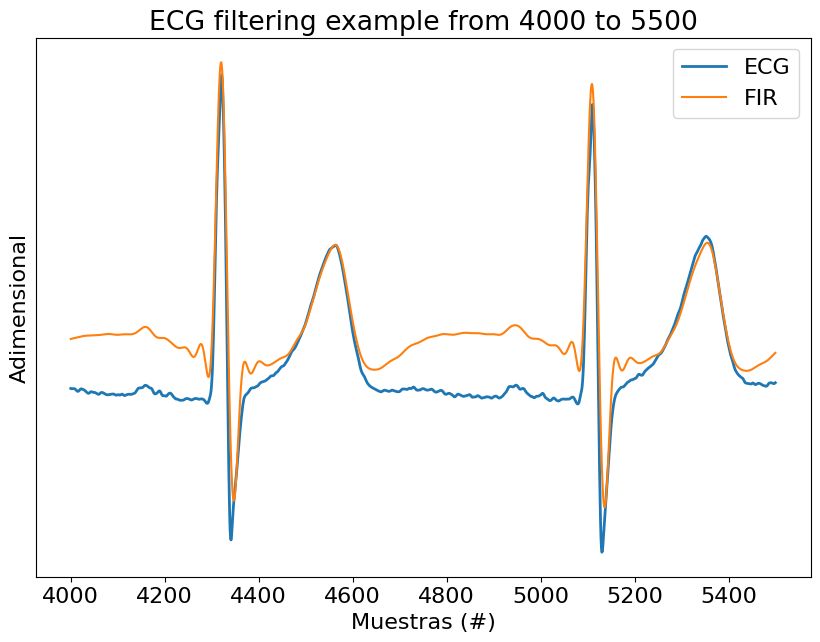

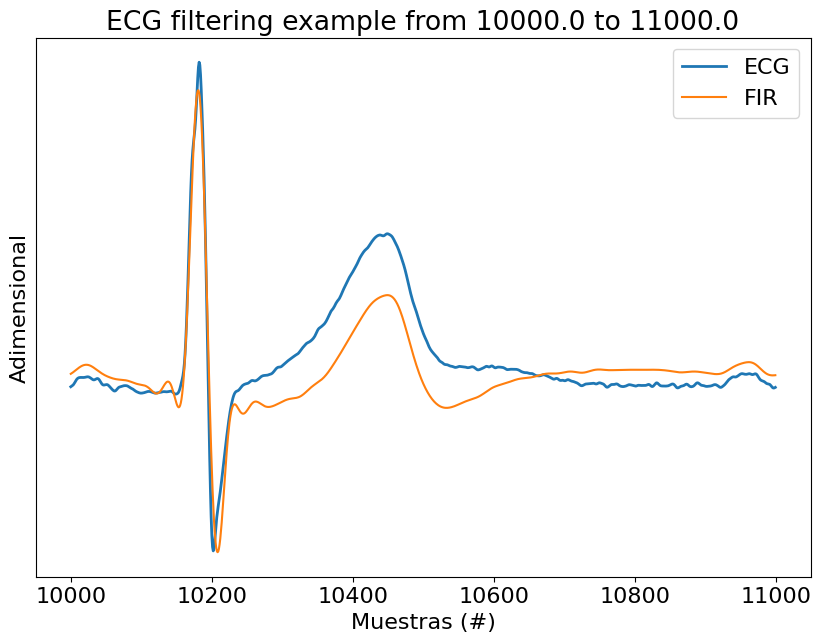

In [11]:
# ------------------------- Análisis para latidos con baja contaminación --------------------------

regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
    

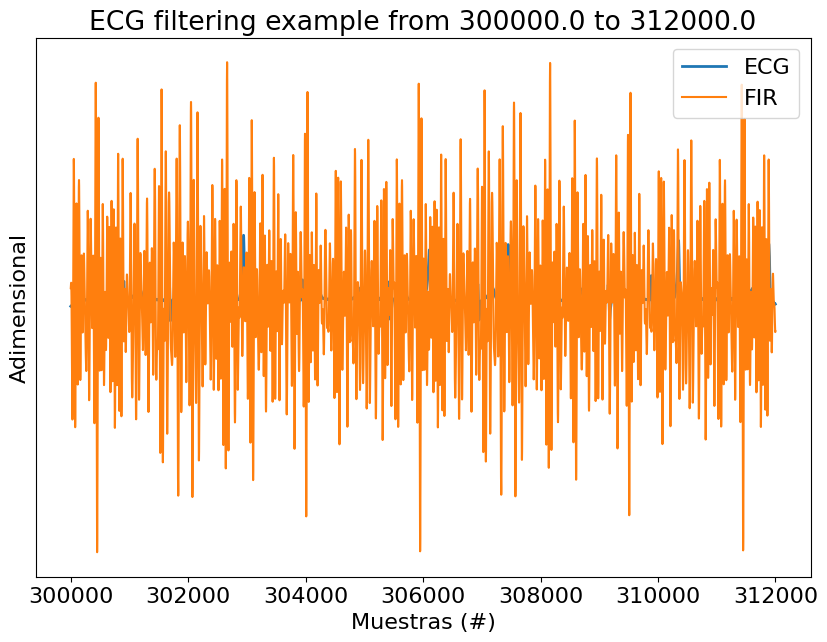

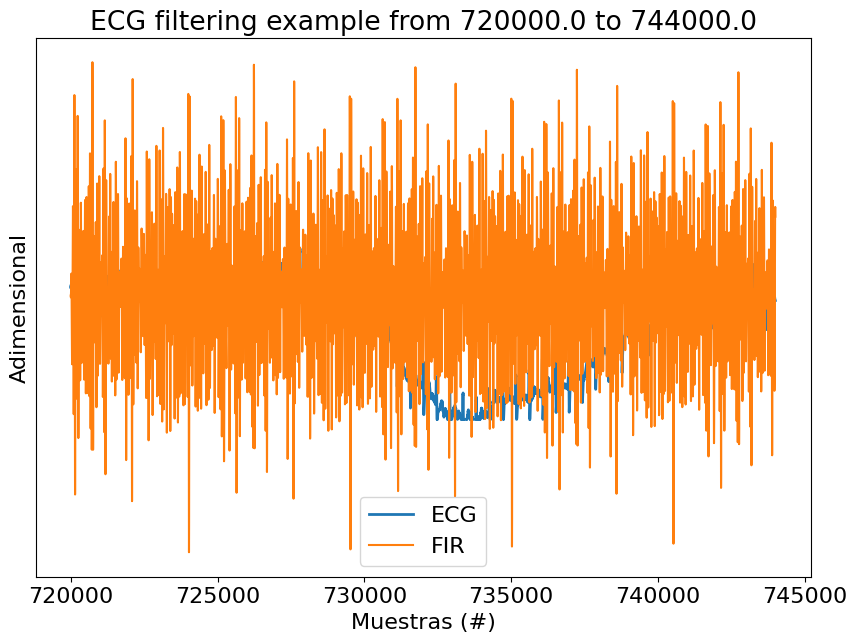

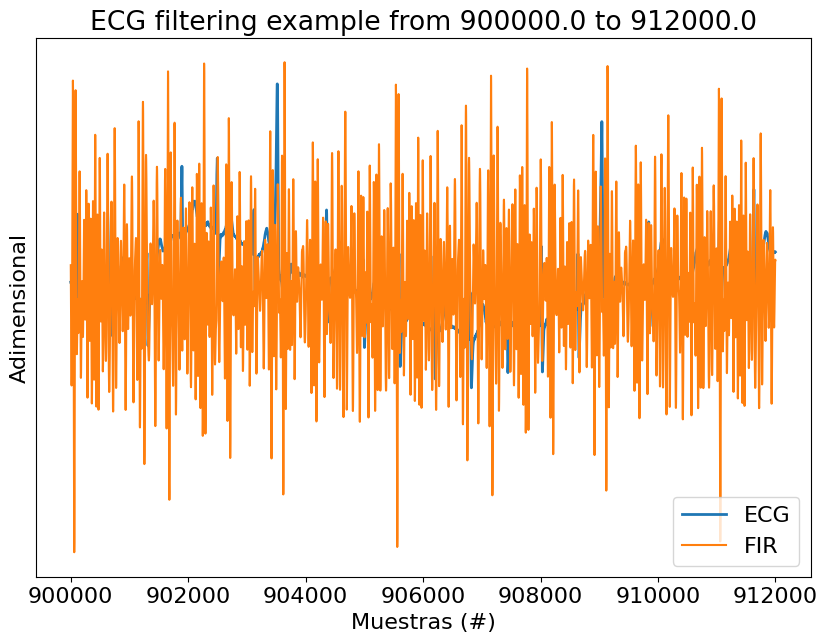

In [27]:
# ------------------------------------- Filtrado bidireccional -------------------------------------

# Utilizamos el filtrado bidireccional en el FIR para eliminar la distorsión de fase

# -------------------------- Segmentos de interés con ALTA contaminación ---------------------------

# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_FIR = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2])   * 60 * fs, # minutos a muestras
        np.array([12, 12.4]) * 60 * fs, # minutos a muestras
        np.array([15, 15.2]) * 60 * fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
    

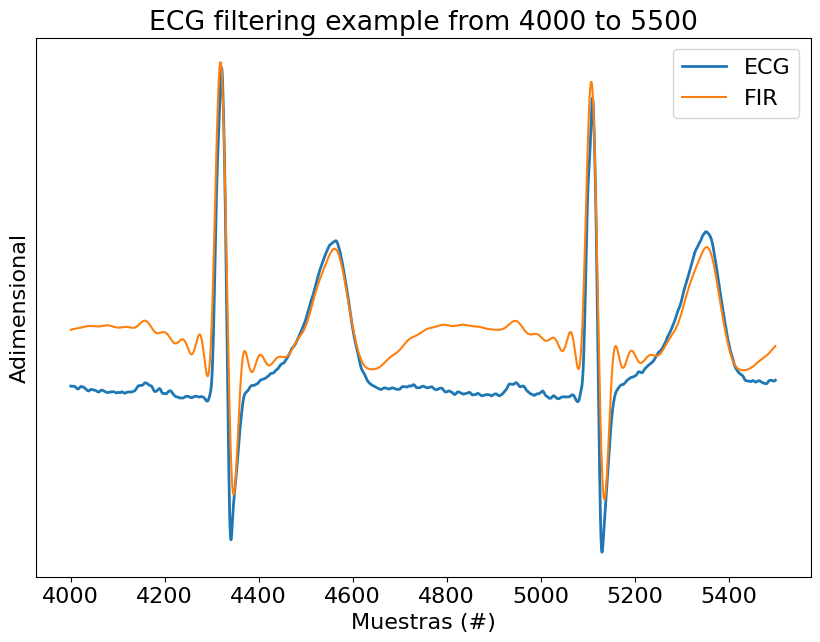

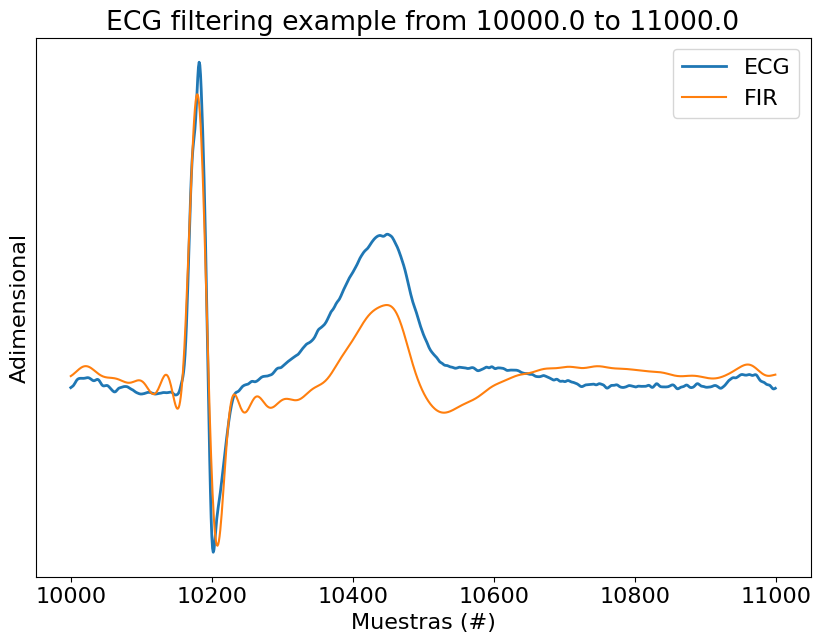

In [13]:
# ------------------------- Análisis para latidos con baja contaminación --------------------------
    
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología, a pesar de que la fase no pudo haber sido la responsable luego de haber usado el filtrado bidireccional. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como oscilaciones que no estaban presentes en el ECG original. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.

1. ¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?

Uno de los motivos por los cuales el filtrado puede no haber sido eficiente para eliminar las interferencias es por el nivel de ruido. Si la señal de entrada contiene un alto nivel de ruido, se dificulta eliminar las interferencias sin afectar negativamente a la señal original. 

2. ¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?

Se le puede adjudicar este error al hecho de que en el diseño del filtro no se puede obtener un riple de exactamente 0dB, lo cual provoca una leve diferencia entre lo filtrado y la señal original. Ademas se observa que los picos del ECG son muy similares a un impulso, por lo cual, la respuesta al impulso tambien afecta al comportamiento del filtro.

Tambien hay que tener en cuenta para ambas respuestas la limitacion de resolución o precisión numérica, los filtros digitales pueden no ser capaces de eliminar eficazmente las interferencias más pequeñas o pueden introducir errores debido a la representación finita de los números en punto flotante.